# Voice Recognition: Buka Tutup Classification

## Data Understanding 

### 1. Import Libraries
Import library dasar untuk analisis data dan audio processing.


In [3]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display
import IPython.display as ipd

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!



### 2. Setup Path Dataset  
Setup path dataset dan cek struktur folder dataset48k.


In [4]:
# Setup dataset path
dataset_path = "dataset48k"

# Check if dataset exists
if os.path.exists(dataset_path):
    print("✅ Dataset found!")
    
    # List directory structure
    print("\n📁 Dataset Structure:")
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
else:
    print("❌ Dataset not found! Please check the path.")

✅ Dataset found!

📁 Dataset Structure:
dataset48k/
  train/
    buka/
    tutup/
  val/
    buka/
    tutup/



### 3. Cek Distribusi Data
Analisis distribusi file audio per kelas dan split data train/validation.


📊 DATA DISTRIBUTION


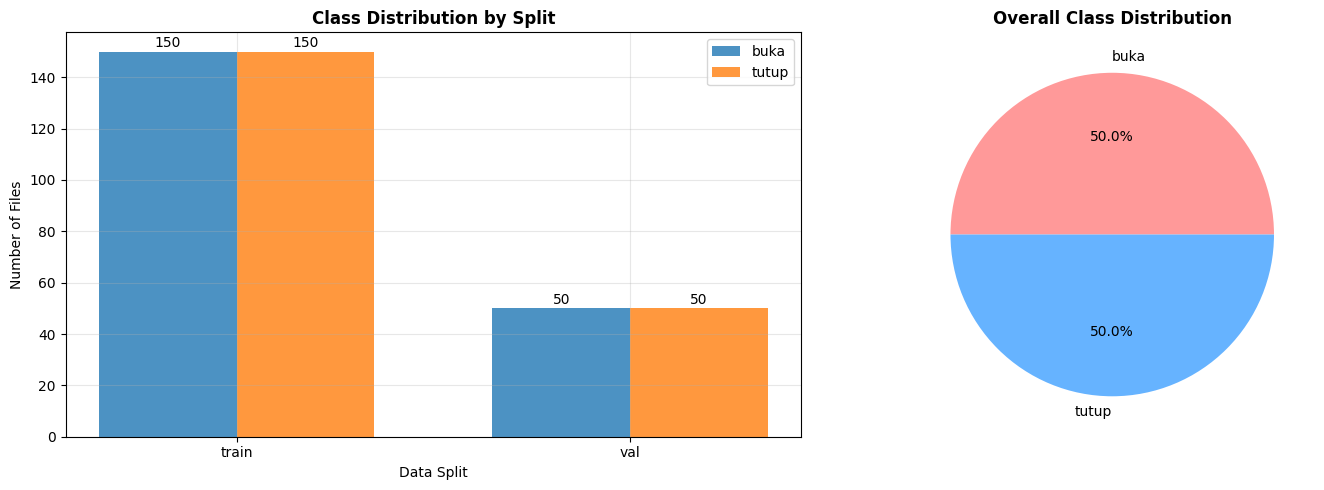


📈 SUMMARY:
TRAIN:
  └── buka: 150 files
  └── tutup: 150 files
VAL:
  └── buka: 50 files
  └── tutup: 50 files

🎯 TOTAL: 400 audio files


In [5]:
def check_data_distribution(base_path):
    """Check distribution of data across classes and splits"""
    print("📊 DATA DISTRIBUTION")
    print("=" * 40)
    
    distribution = {}
    
    for split in ['train', 'val']:
        split_path = os.path.join(base_path, split)
        distribution[split] = {}
        
        if os.path.exists(split_path):
            for class_name in ['buka', 'tutup']:
                class_path = os.path.join(split_path, class_name)
                if os.path.exists(class_path):
                    files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
                    distribution[split][class_name] = len(files)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Overall distribution
    splits = list(distribution.keys())
    buka_counts = [distribution[split].get('buka', 0) for split in splits]
    tutup_counts = [distribution[split].get('tutup', 0) for split in splits]
    
    x = np.arange(len(splits))
    width = 0.35
    
    ax1.bar(x - width/2, buka_counts, width, label='buka', alpha=0.8)
    ax1.bar(x + width/2, tutup_counts, width, label='tutup', alpha=0.8)
    ax1.set_xlabel('Data Split')
    ax1.set_ylabel('Number of Files')
    ax1.set_title('Class Distribution by Split', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(splits)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(buka_counts):
        ax1.text(i - width/2, v + 0.5, str(v), ha='center', va='bottom')
    for i, v in enumerate(tutup_counts):
        ax1.text(i + width/2, v + 0.5, str(v), ha='center', va='bottom')
    
    # Pie chart for overall class distribution
    total_buka = sum(buka_counts)
    total_tutup = sum(tutup_counts)
    ax2.pie([total_buka, total_tutup], labels=['buka', 'tutup'], autopct='%1.1f%%', 
            colors=['#ff9999', '#66b3ff'])
    ax2.set_title('Overall Class Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n📈 SUMMARY:")
    for split in splits:
        print(f"{split.upper()}:")
        for class_name in ['buka', 'tutup']:
            count = distribution[split].get(class_name, 0)
            print(f"  └── {class_name}: {count} files")
    
    total_files = total_buka + total_tutup
    print(f"\n🎯 TOTAL: {total_files} audio files")
    
    return distribution

# Check distribution
data_dist = check_data_distribution(dataset_path)


### 4. Contoh Audio + Metadata
Play sample audio dan visualisasi waveform + spectrogram untuk setiap kelas.


In [6]:
def display_samples_and_save_metadata(base_path):
    """Display sample audio and save all metadata to CSV"""
    print("🎵 AUDIO SAMPLES & METADATA COLLECTION")
    print("=" * 50)
    
    audio_metadata = []
    
    # Collect metadata from all files
    for split in ['train', 'val']:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            for class_name in ['buka', 'tutup']:
                class_path = os.path.join(split_path, class_name)
                if os.path.exists(class_path):
                    files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
                    
                    for file in files:
                        file_path = os.path.join(class_path, file)
                        try:
                            y, sr = librosa.load(file_path, sr=None)
                            duration = librosa.get_duration(y=y, sr=sr)
                            
                            metadata = {
                                'filename': file,
                                'file_path': file_path,
                                'split': split,
                                'class': class_name,
                                'duration': duration,
                                'sample_rate': sr,
                                'num_samples': len(y)
                            }
                            audio_metadata.append(metadata)
                            
                        except Exception as e:
                            print(f"❌ Error processing {file}: {e}")
    
    # Convert to DataFrame
    metadata_df = pd.DataFrame(audio_metadata)
    
    if metadata_df.empty:
        print("❌ No metadata collected!")
        return pd.DataFrame()
    
    # Display sample audio files
    print("\n🎧 SAMPLE AUDIO FILES:")
    print("-" * 30)
    
    # Display 2 samples (1 from each class)
    for class_name in ['buka', 'tutup']:
        sample = metadata_df[metadata_df['class'] == class_name].iloc[0]
        print(f"\n📄 {class_name.upper()} Sample:")
        print(f"   File: {sample['filename']}")
        print(f"   Split: {sample['split']}")
        print(f"   Duration: {sample['duration']:.2f}s")
        print(f"   Sample Rate: {sample['sample_rate']} Hz")
        
        # Play audio
        try:
            y, sr = librosa.load(sample['file_path'], sr=None)
            ipd.display(ipd.Audio(y, rate=sr))
        except Exception as e:
            print(f"❌ Error playing audio: {e}")
    
    # Save to CSV
    csv_filename = "audio_metadata.csv"
    metadata_df.to_csv(csv_filename, index=False)
    
    print(f"\n💾 METADATA SAVED TO: {csv_filename}")
    print(f"📊 Total files: {len(metadata_df)}")
    print(f"📁 File size: {os.path.getsize(csv_filename) / 1024:.2f} KB")
    
    # Show quick preview
    print(f"\n📋 METADATA PREVIEW:")
    print(metadata_df[['filename', 'split', 'class', 'duration']].head())
    
    return metadata_df

# Run the function
metadata_df = display_samples_and_save_metadata(dataset_path)

🎵 AUDIO SAMPLES & METADATA COLLECTION

🎧 SAMPLE AUDIO FILES:
------------------------------

📄 BUKA Sample:
   File: buka48k-buka_36.wav.wav
   Split: train
   Duration: 3.76s
   Sample Rate: 48000 Hz



📄 TUTUP Sample:
   File: tutup48k-tutup_127.wav.wav
   Split: train
   Duration: 2.52s
   Sample Rate: 48000 Hz



💾 METADATA SAVED TO: audio_metadata.csv
📊 Total files: 400
📁 File size: 44.00 KB

📋 METADATA PREVIEW:
                   filename  split class  duration
0   buka48k-buka_36.wav.wav  train  buka  3.764354
1  buka48k-buka_132.wav.wav  train  buka  2.429396
2  buka48k-buka_135.wav.wav  train  buka  2.174333
3  buka48k-buka_102.wav.wav  train  buka  3.034292
4   buka48k-buka_32.wav.wav  train  buka  3.764354



### 5. Analisis Durasi dan Sample Rate
Analisis statistik durasi audio dan konsistensi sample rate dataset.


🎵 SAMPLE AUDIO ANALYSIS

📄 BUKA Sample:
   File: buka48k-buka_36.wav.wav
   Duration: 3.76s
   Sample Rate: 48000 Hz
   Samples: 180,689



📄 TUTUP Sample:
   File: tutup48k-tutup_127.wav.wav
   Duration: 2.52s
   Sample Rate: 48000 Hz
   Samples: 121,167


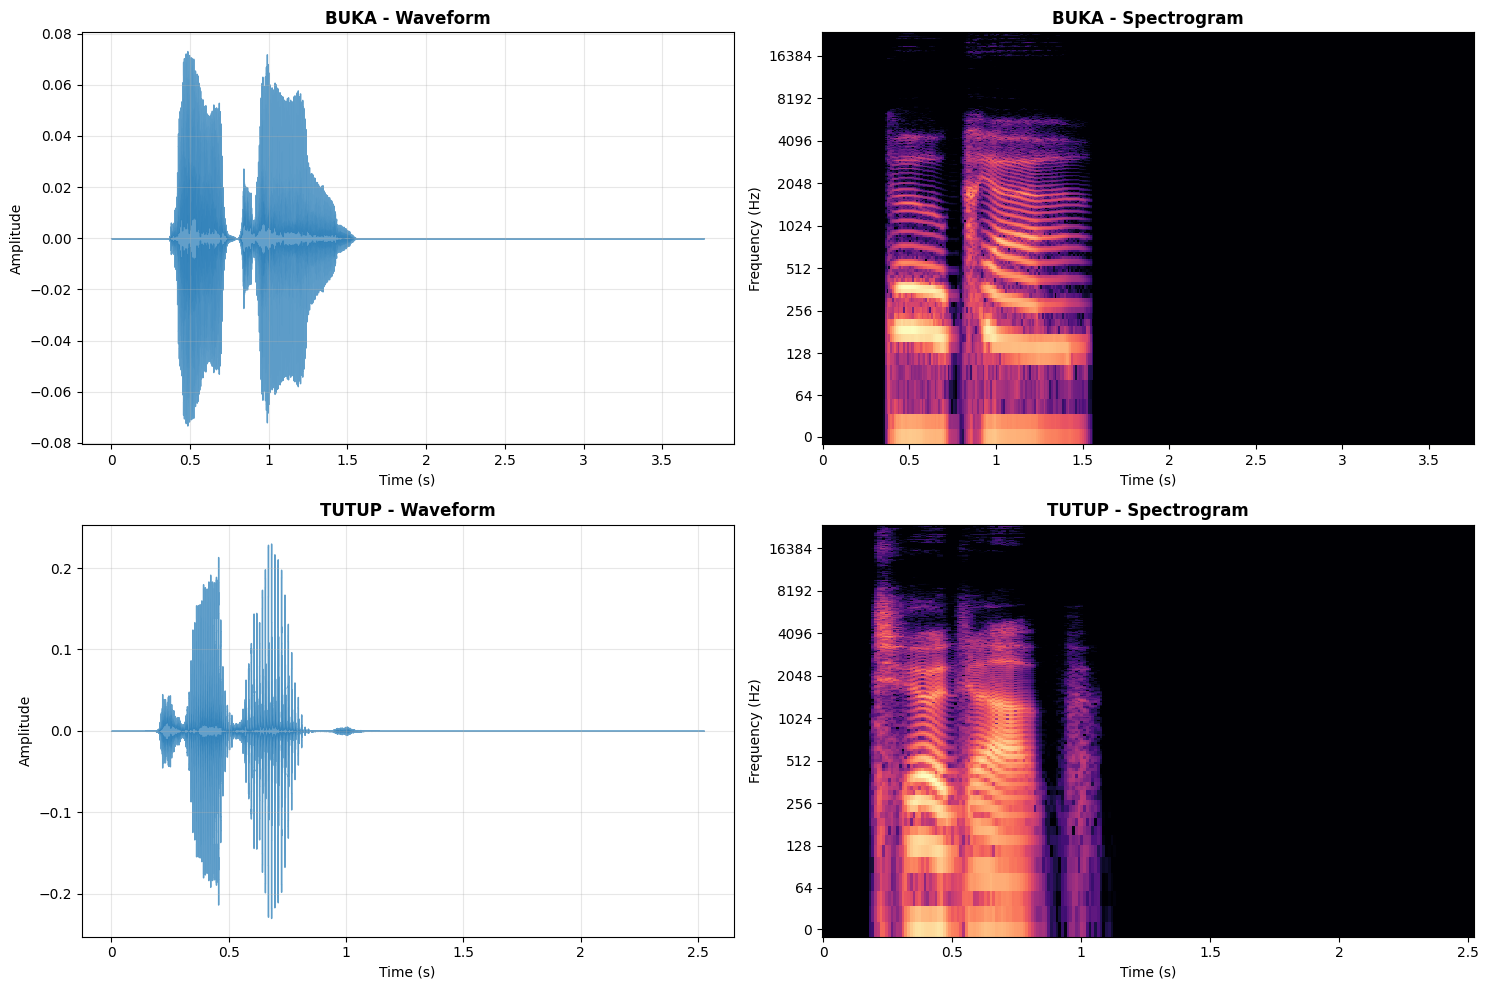

In [7]:
def analyze_sample_audio(base_path):
    """Analyze sample audio files and their metadata"""
    print("🎵 SAMPLE AUDIO ANALYSIS")
    print("=" * 40)
    
    sample_data = []
    
    # Collect sample from each class
    for class_name in ['buka', 'tutup']:
        class_path = os.path.join(base_path, 'train', class_name)
        if os.path.exists(class_path):
            files = [f for f in os.listdir(class_path) if f.endswith('.wav')][:1]  # Take first file
            
            for file in files:
                file_path = os.path.join(class_path, file)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                    duration = librosa.get_duration(y=y, sr=sr)
                    
                    sample_data.append({
                        'class': class_name,
                        'filename': file,
                        'duration': duration,
                        'sample_rate': sr,
                        'samples': len(y),
                        'audio': y,
                        'sr': sr
                    })
                    
                    print(f"\n📄 {class_name.upper()} Sample:")
                    print(f"   File: {file}")
                    print(f"   Duration: {duration:.2f}s")
                    print(f"   Sample Rate: {sr} Hz")
                    print(f"   Samples: {len(y):,}")
                    
                    # Display audio player
                    ipd.display(ipd.Audio(y, rate=sr))
                    
                except Exception as e:
                    print(f"❌ Error loading {file_path}: {e}")
    
    # Create visualization for samples
    if sample_data:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        for idx, sample in enumerate(sample_data):
            y, sr, class_name = sample['audio'], sample['sr'], sample['class']
            
            # Waveform
            librosa.display.waveshow(y, sr=sr, ax=axes[idx, 0], alpha=0.7)
            axes[idx, 0].set_title(f'{class_name.upper()} - Waveform', fontweight='bold')
            axes[idx, 0].set_xlabel('Time (s)')
            axes[idx, 0].set_ylabel('Amplitude')
            axes[idx, 0].grid(True, alpha=0.3)
            
            # Spectrogram
            D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
            librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=axes[idx, 1])
            axes[idx, 1].set_title(f'{class_name.upper()} - Spectrogram', fontweight='bold')
            axes[idx, 1].set_xlabel('Time (s)')
            axes[idx, 1].set_ylabel('Frequency (Hz)')
        
        plt.tight_layout()
        plt.show()
    
    return sample_data

# Analyze samples
samples = analyze_sample_audio(dataset_path)


### 6. Deteksi Missing Value dan Outlier
Deteksi masalah data seperti missing values dan outlier durasi audio.


⏱️ DURATION & SAMPLE RATE ANALYSIS


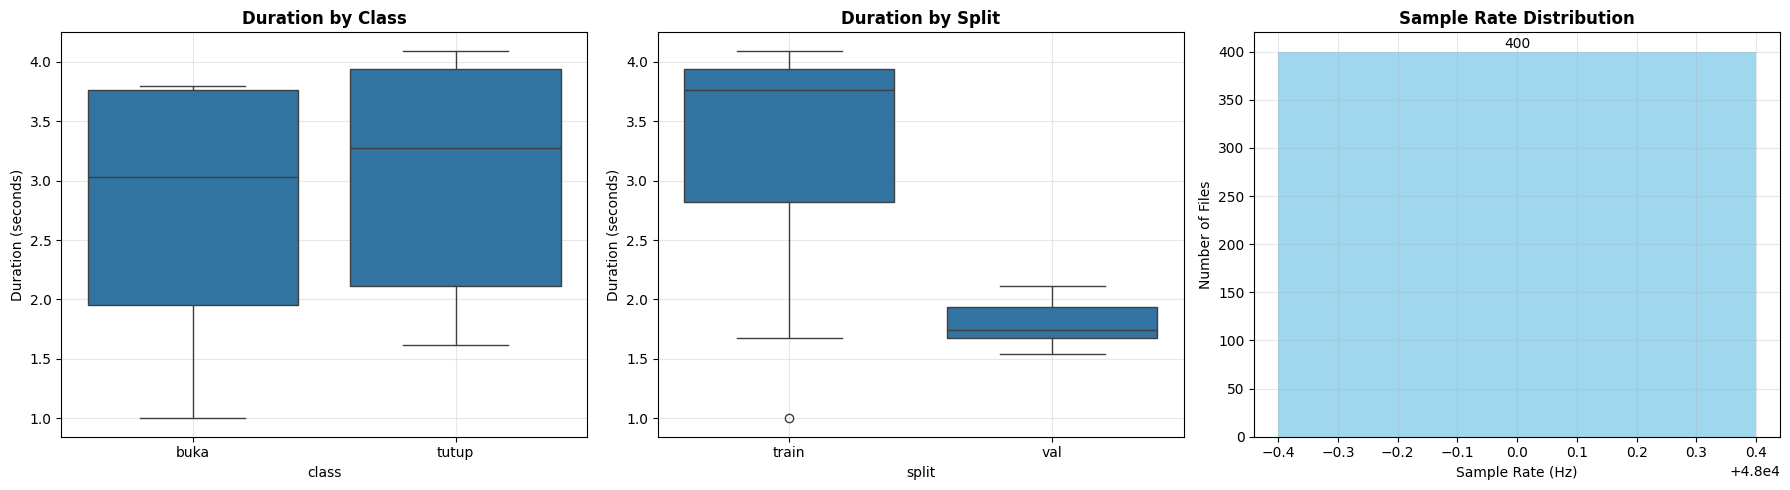


📊 DURATION STATISTICS:
       count   mean    std    min    25%    50%    75%    max
class                                                        
buka   200.0  2.907  0.882  0.999  1.949  3.034  3.764  3.794
tutup  200.0  3.091  0.937  1.614  2.109  3.279  3.944  4.094

🎯 SAMPLE RATES: [48000]


In [8]:
def analyze_duration_sample_rate(base_path):
    """Analyze duration and sample rate distribution"""
    print("⏱️ DURATION & SAMPLE RATE ANALYSIS")
    print("=" * 40)
    
    audio_info = []
    
    # Collect data from all files
    for split in ['train', 'val']:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            for class_name in ['buka', 'tutup']:
                class_path = os.path.join(split_path, class_name)
                if os.path.exists(class_path):
                    files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
                    
                    for file in files:
                        file_path = os.path.join(class_path, file)
                        try:
                            y, sr = librosa.load(file_path, sr=None)
                            duration = librosa.get_duration(y=y, sr=sr)
                            
                            audio_info.append({
                                'split': split,
                                'class': class_name,
                                'filename': file,
                                'duration': duration,
                                'sample_rate': sr
                            })
                            
                        except Exception as e:
                            print(f"❌ Error loading {file_path}: {e}")
    
    audio_df = pd.DataFrame(audio_info)
    
    if audio_df.empty:
        print("❌ No audio data found!")
        return pd.DataFrame()
    
    # Create visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Duration distribution by class
    sns.boxplot(data=audio_df, x='class', y='duration', ax=axes[0])
    axes[0].set_title('Duration by Class', fontweight='bold')
    axes[0].set_ylabel('Duration (seconds)')
    axes[0].grid(True, alpha=0.3)
    
    # Duration distribution by split
    sns.boxplot(data=audio_df, x='split', y='duration', ax=axes[1])
    axes[1].set_title('Duration by Split', fontweight='bold')
    axes[1].set_ylabel('Duration (seconds)')
    axes[1].grid(True, alpha=0.3)
    
    # Sample rate distribution
    sample_rate_counts = audio_df['sample_rate'].value_counts()
    axes[2].bar(sample_rate_counts.index, sample_rate_counts.values, color='skyblue', alpha=0.8)
    axes[2].set_title('Sample Rate Distribution', fontweight='bold')
    axes[2].set_xlabel('Sample Rate (Hz)')
    axes[2].set_ylabel('Number of Files')
    axes[2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(sample_rate_counts.values):
        axes[2].text(sample_rate_counts.index[i], v + 0.5, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n📊 DURATION STATISTICS:")
    duration_stats = audio_df.groupby('class')['duration'].describe()
    print(duration_stats.round(3))
    
    print(f"\n🎯 SAMPLE RATES: {audio_df['sample_rate'].unique()}")
    
    return audio_df

# Analyze duration and sample rate
audio_df = analyze_duration_sample_rate(dataset_path)


### 7. Final Data Understanding Summary
Ringkasan akhir karakteristik dataset sebelum preprocessing.

🔍 MISSING VALUES & OUTLIERS DETECTION
✅ MISSING VALUES CHECK:
   No missing values found! 🎉

✅ OUTLIERS DETECTION:
   Duration statistics:
   └── Q1: 2.109s, Q3: 3.794s, IQR: 1.685s
   └── Lower bound: -0.418s, Upper bound: 6.322s
   └── Outliers found: 0 files


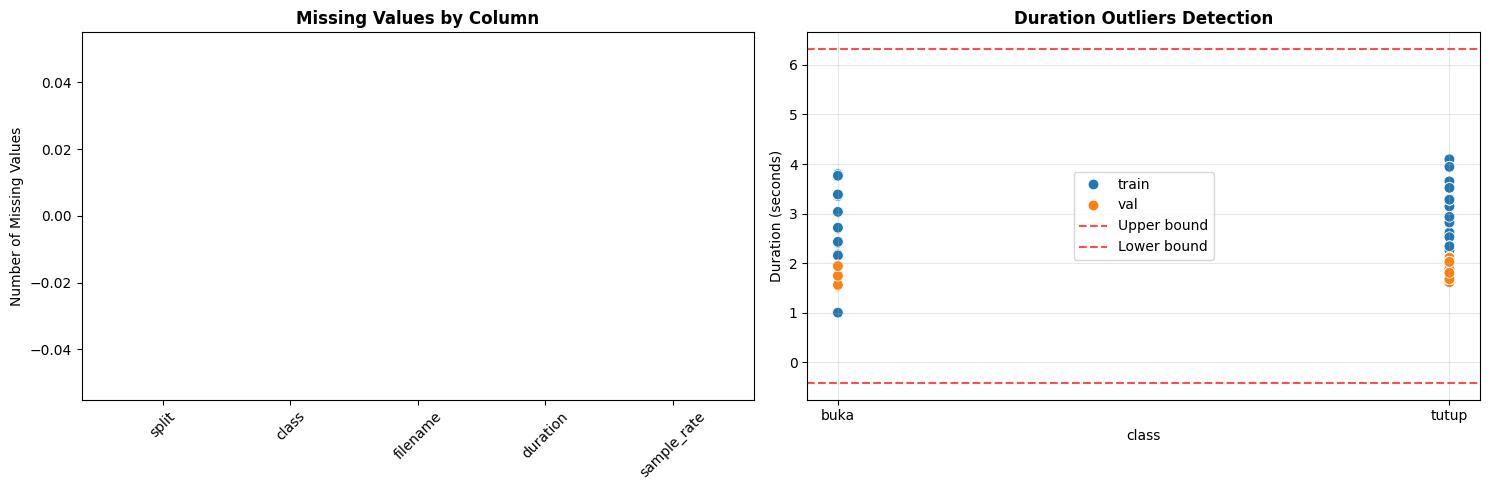


📋 DATA QUALITY SUMMARY:
   ✅ Total files: 400
   ✅ Missing values: 0
   ✅ Duration outliers: 0
   ✅ Sample rate consistency: True

🎉 Excellent data quality! Ready for preprocessing.


In [9]:
def detect_issues(audio_df):
    """Detect missing values and outliers"""
    print("🔍 MISSING VALUES & OUTLIERS DETECTION")
    print("=" * 40)
    
    if audio_df.empty:
        print("❌ No data for analysis!")
        return
    
    # Check for missing values
    missing_values = audio_df.isnull().sum()
    total_missing = missing_values.sum()
    
    print("✅ MISSING VALUES CHECK:")
    if total_missing == 0:
        print("   No missing values found! 🎉")
    else:
        print("   Missing values found:")
        for col, count in missing_values[missing_values > 0].items():
            print(f"   └── {col}: {count} missing values")
    
    # Check for outliers in duration
    print(f"\n✅ OUTLIERS DETECTION:")
    
    # Using IQR method for outliers
    Q1 = audio_df['duration'].quantile(0.25)
    Q3 = audio_df['duration'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = audio_df[(audio_df['duration'] < lower_bound) | (audio_df['duration'] > upper_bound)]
    
    print(f"   Duration statistics:")
    print(f"   └── Q1: {Q1:.3f}s, Q3: {Q3:.3f}s, IQR: {IQR:.3f}s")
    print(f"   └── Lower bound: {lower_bound:.3f}s, Upper bound: {upper_bound:.3f}s")
    print(f"   └── Outliers found: {len(outliers)} files")
    
    if len(outliers) > 0:
        print(f"   └── Outlier files:")
        for idx, row in outliers.iterrows():
            print(f"       {row['class']}/{row['filename']}: {row['duration']:.3f}s")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Missing values visualization
    colors = ['red' if x > 0 else 'green' for x in missing_values]
    bars = axes[0].bar(missing_values.index, missing_values.values, color=colors, alpha=0.7)
    axes[0].set_title('Missing Values by Column', fontweight='bold')
    axes[0].set_ylabel('Number of Missing Values')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, missing_values.values):
        if value > 0:
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                        str(value), ha='center', va='bottom')
    
    # Outliers visualization
    sns.scatterplot(data=audio_df, x='class', y='duration', hue='split', ax=axes[1], s=60)
    axes[1].axhline(y=upper_bound, color='r', linestyle='--', alpha=0.7, label='Upper bound')
    axes[1].axhline(y=lower_bound, color='r', linestyle='--', alpha=0.7, label='Lower bound')
    axes[1].set_title('Duration Outliers Detection', fontweight='bold')
    axes[1].set_ylabel('Duration (seconds)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Final summary
    print(f"\n📋 DATA QUALITY SUMMARY:")
    print(f"   ✅ Total files: {len(audio_df)}")
    print(f"   ✅ Missing values: {total_missing}")
    print(f"   ✅ Duration outliers: {len(outliers)}")
    print(f"   ✅ Sample rate consistency: {len(audio_df['sample_rate'].unique()) == 1}")
    
    if len(outliers) == 0 and total_missing == 0:
        print(f"\n🎉 Excellent data quality! Ready for preprocessing.")

# Detect issues
if not audio_df.empty:
    detect_issues(audio_df)

In [10]:
def final_summary(audio_df, data_dist):
    """Final summary of data understanding"""
    print("📋 FINAL DATA UNDERSTANDING SUMMARY")
    print("=" * 50)
    
    if audio_df.empty:
        print("❌ No data available for summary!")
        return
    
    print(f"\n🎯 DATASET OVERVIEW:")
    print(f"   ├── Total audio files: {len(audio_df)}")
    print(f"   ├── Classes: {audio_df['class'].nunique()} (buka, tutup)")
    print(f"   ├── Splits: {audio_df['split'].nunique()} (train, val)")
    print(f"   └── Average duration: {audio_df['duration'].mean():.2f}s")
    
    print(f"\n📊 DATA DISTRIBUTION:")
    for split in ['train', 'val']:
        split_data = audio_df[audio_df['split'] == split]
        print(f"   {split.upper()}:")
        for class_name in ['buka', 'tutup']:
            count = len(split_data[split_data['class'] == class_name])
            print(f"     └── {class_name}: {count} files")
    
    print(f"\n🎵 AUDIO CHARACTERISTICS:")
    print(f"   ├── Sample rate: {audio_df['sample_rate'].iloc[0]} Hz (consistent)")
    print(f"   ├── Duration range: {audio_df['duration'].min():.2f}s - {audio_df['duration'].max():.2f}s")
    print(f"   └── Total audio time: {audio_df['duration'].sum()/60:.1f} minutes")
    
    print(f"\n✅ DATA QUALITY:")
    print(f"   ├── Missing values: {audio_df.isnull().sum().sum()}")
    outliers = len(audio_df[(audio_df['duration'] < 0.1) | (audio_df['duration'] > 10)])
    print(f"   ├── Potential outliers: {outliers}")
    print(f"   └── Ready for preprocessing: {'YES' if audio_df.isnull().sum().sum() == 0 else 'NO'}")

# Final summary
if not audio_df.empty:
    final_summary(audio_df, data_dist)

📋 FINAL DATA UNDERSTANDING SUMMARY

🎯 DATASET OVERVIEW:
   ├── Total audio files: 400
   ├── Classes: 2 (buka, tutup)
   ├── Splits: 2 (train, val)
   └── Average duration: 3.00s

📊 DATA DISTRIBUTION:
   TRAIN:
     └── buka: 150 files
     └── tutup: 150 files
   VAL:
     └── buka: 50 files
     └── tutup: 50 files

🎵 AUDIO CHARACTERISTICS:
   ├── Sample rate: 48000 Hz (consistent)
   ├── Duration range: 1.00s - 4.09s
   └── Total audio time: 20.0 minutes

✅ DATA QUALITY:
   ├── Missing values: 0
   ├── Potential outliers: 0
   └── Ready for preprocessing: YES
